In [2]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, pts, ks, masks = util.load_data('data/processed/ASCADv.h5')
splits_precomputed_poly = pickle.load(open("data/processed/splits_poly.pkl", "rb"))

In [2]:
gs = []

for pc in [1, 2, 3, 5, 10, 20, 50]:
    for C in [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
        pl = make_pipeline(
            LDA(solver='eigen', shrinkage='auto', n_components=pc),
            LogisticRegression(C=C, random_state=SEED, verbose=1)
        )
        results, _ = cv_precomputed(pl, splits_precomputed_poly, verbose=False)
        logging.info(f"[{pc}, {C}]: {results['atk_score_mean'].mean():.4f}")

        gs.append(util.results_to_dict(results, pc=pc, C=C))
        util.save_results(gs, "lda_lr_poly")

11:33:07: [1, 0.0001]: 0.0107
11:34:57: [1, 0.001]: 0.0608
11:36:45: [1, 0.01]: 0.1167
11:38:37: [1, 0.1]: 0.1228
11:40:27: [1, 1]: 0.1227
11:42:18: [1, 10]: 0.1227
11:44:08: [2, 0.0001]: 0.0138
11:45:56: [2, 0.001]: 0.0805
11:47:41: [2, 0.01]: 0.1542
11:49:26: [2, 0.1]: 0.1612
11:51:12: [2, 1]: 0.1611
11:52:57: [2, 10]: 0.1611
11:54:48: [3, 0.0001]: 0.0143
11:56:38: [3, 0.001]: 0.0832
11:58:24: [3, 0.01]: 0.1586
12:00:10: [3, 0.1]: 0.1652
12:01:57: [3, 1]: 0.1650
12:03:44: [3, 10]: 0.1649
12:05:35: [5, 0.0001]: 0.0146
12:07:24: [5, 0.001]: 0.0848
12:09:12: [5, 0.01]: 0.1601
12:11:04: [5, 0.1]: 0.1658
12:12:57: [5, 1]: 0.1654
12:14:50: [5, 10]: 0.1653
12:16:42: [10, 0.0001]: 0.0146
12:18:24: [10, 0.001]: 0.0849
12:20:14: [10, 0.01]: 0.1549
12:22:11: [10, 0.1]: 0.1576
12:24:07: [10, 1]: 0.1568
12:26:04: [10, 10]: 0.1566
12:27:56: [20, 0.0001]: 0.0147
12:29:45: [20, 0.001]: 0.0838
12:31:42: [20, 0.01]: 0.1453
12:33:43: [20, 0.1]: 0.1421
12:35:46: [20, 1]: 0.1403
12:37:49: [20, 10]: 0.140

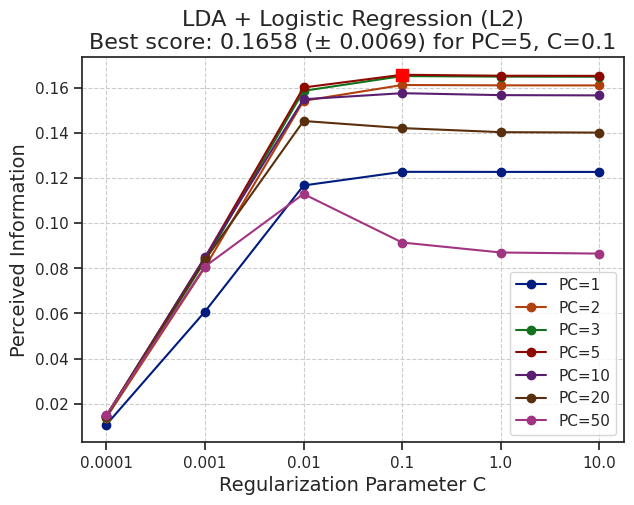

: 

In [ ]:
df = pd.read_csv("data/results/lda_lr_poly.csv")
fig, ax = plt.subplots(figsize=(7, 5))

C = sorted(df['C'].unique())
xaxis = np.arange(len(C))

for pc in sorted(df['pc'].unique()):
    subset = df[df['pc'] == pc]
    ax.plot(
        xaxis,
        subset['atk_score_mean'],
        label=f'PC={pc}',
        marker='o',
    )

best_idx = df['atk_score_mean'].idxmax()
best_row = df.loc[best_idx]

ax.scatter(
    xaxis[C.index(best_row['C'])],
    best_row['atk_score_mean'],
    s=80, marker='s', color='red', zorder=5,
)
ax.set_xticks(xaxis)
ax.set_xticklabels(C)
ax.grid(True, linestyle='--', linewidth=0.8)
ax.legend(loc='lower right')
plots.labs(
    ax,
    title=f"LDA + Logistic Regression (L2)\n" \
          f"Best score: {best_row['atk_score_mean']:.4f} (± {best_row['atk_score_std']:.4f}) for PC={int(best_row['pc'])}, C={best_row['C']}",
    ylab="Perceived Information",
    xlab='Regularization Parameter C',
)
plots.savetight(fig, "08_lda_lr_poly")

In [ ]:
from sklearn.preprocessing import QuantileTransformer

gs = []

for pc in [1, 2, 3, 5, 10, 20, 50]:
    pl = make_pipeline(
        QuantileTransformer(output_distribution='normal', random_state=SEED),
        LDA(solver='eigen', shrinkage='auto', n_components=pc),
        LogisticRegression(C=1e-2, random_state=SEED, verbose=1)
    )
    results, _ = cv_precomputed(pl, splits_precomputed_poly, verbose=False)
    logging.info(f"[{pc}]: {results['atk_score_mean'].mean():.4f}")

    gs.append(util.results_to_dict(results, pc=pc, C=1e-2))
    util.save_results(gs, "quantile_lda_lr_poly")

In [2]:
lda = LDA(solver='eigen', shrinkage='auto', n_components=1)
pl = make_pipeline(
    SelectFromModel(simplerf(SEED), max_features=100),
    StandardScaler(),
    PolynomialFeatures(degree=(2, 2), interaction_only=True, include_bias=False),
    SelectKBest(f_classif, k=750),
    lda,
).fit(X, y)

18:58:08: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18:58:08: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18:58:08: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18:58:08: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


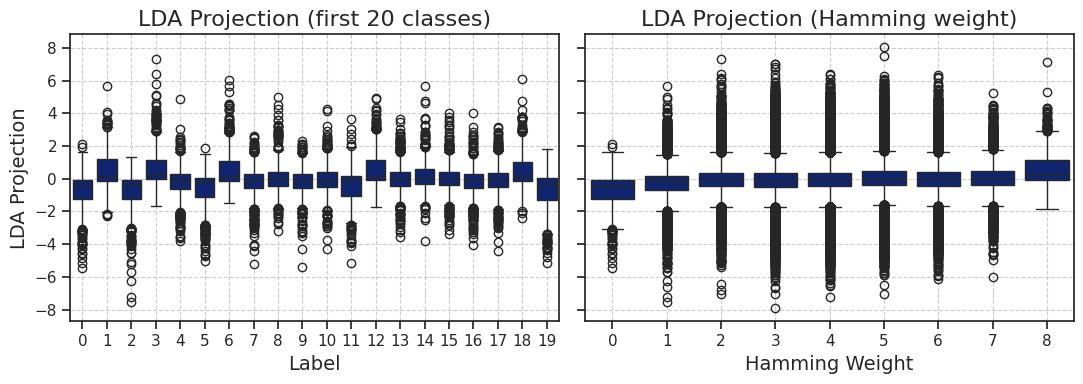

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

Z = pl.transform(X).reshape(-1)

df = pd.DataFrame({'Z': Z, 'y': y})
sns.boxplot(df[df['y'].isin(range(20))], x='y', y='Z', ax=ax1)
ax1.grid(True, linestyle='--', linewidth=0.8)
plots.labs(ax1,
    title="LDA Projection (first 20 classes)",
    xlab="Label",
    ylab="LDA Projection",
)

df = pd.DataFrame({'Z': Z, 'y': util.hw(y)})
sns.boxplot(df[df['y'].isin(range(10))], x='y', y='Z', ax=ax2)
ax2.grid(True, linestyle='--', linewidth=0.8)
plots.labs(ax2,
    title="LDA Projection (Hamming weight)",
    xlab="Hamming Weight",
    ylab="",
)

fig.tight_layout()
plots.savetight(fig, "08_lda_lr_lda_projection")

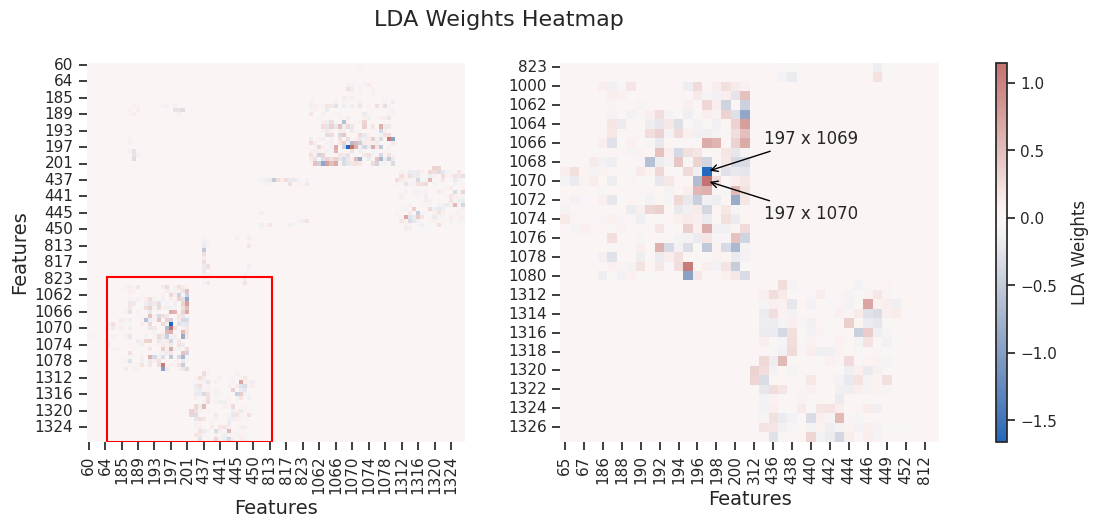

: 

In [ ]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pl_info = util.inspect_pipeline(pl)
feats = pl_info['selected_features']

R = pd.DataFrame(np.zeros((len(feats), len(feats))), index=feats, columns=feats)

for weight, (a, b) in zip(lda.scalings_[0], pl_info['pairs']):
    R.loc[a, b] = R.loc[b, a] = weight

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
fig.subplots_adjust(wspace=0.25)

sns.heatmap(R, cmap='vlag', center=0, ax=ax1,
            square=True, cbar=False)
plots.labs(ax1, xlab="Features", ylab="Features")

sns.heatmap(R.iloc[-40:, 5:45], cmap='vlag',
            center=0, ax=ax2, square=True, cbar=False)
plots.labs(ax2, xlab="Features", ylab="")

y0 = len(feats) - 40
x0 = 5
rect = Rectangle((x0, y0), 40, 40, linewidth=1.5, edgecolor='red', facecolor='none')
ax1.add_patch(rect)

ax2.annotate("197 x 1069", xy=(15.5, 11.5), xycoords='data',
            xytext=(26.5, 8.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", color='black'),
            fontsize=12, ha='center')

ax2.annotate("197 x 1070", xy=(15.5, 12.5), xycoords='data',
            xytext=(26.5, 16.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", color='black'),
            fontsize=12, ha='center')

cax = inset_axes(
    ax2, width="3%", height="100%", loc="lower left",
    bbox_to_anchor=(1.15, 0, 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0,
 )
cbar = fig.colorbar(ax2.collections[0], cax=cax)
cbar.set_label("LDA Weights", labelpad=10)

fig.suptitle("LDA Weights Heatmap", fontsize=16)
plots.savetight(fig, "08_lda_lr_lda_weights")